In [ ]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
import PIL.Image
from pathlib import Path
import torchvision

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import json
import time
import timm

In [ ]:
IMAGE_SIZE = 128
BATCH_SIZE = 32
nfolds = 4
fname = 'resnet50'#'RSNT18'#'resnext50'
IMAGE_DIR = '/kaggle/input/panda-16x128x128-tiles-data/train'
LABELS = '/kaggle/input/prostate-cancer-grade-assessment/train.csv'
SEED = 2024

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# loss_name = "mse"
# TRAIN_DATASET_FRAC = 1
# num_epochs = 50
# EARLY_STOPPING = True
# MIN_EPOCH = 20
# PATIENCE = 10

loss_name = "cross_entropy" #"mse"
TRAIN_DATASET_FRAC = 1
num_epochs = 20
EARLY_STOPPING = True
MIN_EPOCH = 10
PATIENCE = 8

## Seed everything

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

## Dataset class

In [ ]:
class ProstateTilesDataset(torch.utils.data.Dataset):
    def __init__(self, df, image_dir, n_tiles=(3, 4), transform=None):
        self.df = df
        self.image_dir = image_dir
        self.n_tiles = n_tiles
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id = row.image_id
        label = row.isup_grade
        tile_rows, tile_cols = self.n_tiles
        imgs = []
        for i in range(tile_rows):
            for j in range(tile_cols):
                img_path = Path(self.image_dir, f'{img_id}_{i * tile_cols + j}.png')
                img = PIL.Image.open(img_path).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                imgs.append(img)
        imgs = torch.stack(imgs) # (12, 3, 128, 128)
        return imgs, label

## Model

In [ ]:
class CustomPool(nn.Module):
    def __init__(self, N=12):
        super(CustomPool, self).__init__()
        self.avg_pool = nn.AvgPool1d(kernel_size=N)
        self.max_pool = nn.MaxPool1d(kernel_size=N)

    def forward(self, x):
        # x = (BS, 12, 2048)
        x = x.transpose(1, 2)  # (BS, 512, 12)
        avg_pooled = self.avg_pool(x).squeeze(-1)  # (BS, 512)
        max_pooled = self.max_pool(x).squeeze(-1)  # (BS, 512)
        concatenated_features = torch.cat((avg_pooled, max_pooled), dim=1)  # (BS, 512*2)
        return concatenated_features

In [ ]:
class Model(nn.Module):
    def __init__(self, num_classes=6): # change back to 6
        super().__init__()
        #self.enc = timm.create_model('resnet18', pretrained=True, num_classes=0)
        #self.enc = timm.create_model('resnext50_32x4d.fb_ssl_yfcc100m_ft_in1k', pretrained=True, num_classes=0)
        self.enc = timm.create_model('resnet50.a1_in1k', pretrained=True, num_classes=0)


        nc = self.enc.feature_info[-1]['num_chs']
        self.pool = CustomPool()
        self.head = nn.Sequential(
            nn.Linear(nc*2,512), # (BS, 12, 512)
            nn.Mish(),
            nn.Dropout(0.25),
            nn.Linear(512,num_classes)
        )

    def forward(self, x):
        # x = (BS, 12, 3, 128, 128)
        n = x.shape[1]
        x = x.view(-1, x.shape[2], x.shape[3], x.shape[4]) # (BS*12, 3, 128, 128)
        x = self.enc(x) # (BS*12, nc)
        x = x.view(-1,n,x.shape[1]) # (BS, 12, nc)
        x = self.pool(x) # (BS, 512*2)
        x = self.head(x)
        return x

## Training utility functions

In [ ]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    start_time = time.time()
    with tqdm(
        dataloader,
        desc=(f"Epoch {epoch} - Train"),
        unit=" slide",
        unit_scale=BATCH_SIZE,
        leave=False,
    ) as t:
        for inputs, labels in t:
            inputs, labels = inputs.to(device), labels.to(device)
#             labels = labels.float()
            outputs = model(inputs)
            if loss_name == "mse":
                loss = criterion(outputs.squeeze(-1), labels)
            else:
                loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()

    average_loss = total_loss / len(dataloader)
    end_time = time.time()
    return average_loss

In [ ]:
def go_from_mse_logit_to_prediction(logit):
    if logit < 0.5:
        return 0
    elif logit < 1.5:
        return 1
    elif logit < 2.5:
        return 2
    elif logit < 3.5:
        return 3
    elif logit < 4.5:
        return 4
    else:
        return 5

In [ ]:
def tune(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    start_time = time.time()
    with tqdm(
        dataloader,
        desc=(f"Epoch {epoch} - Tune"),
        unit=" slide",
        unit_scale=BATCH_SIZE,
        leave=False,
    ) as t:
        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
#                 labels = labels.float()
                outputs = model(inputs)
                if loss_name == "mse":
                    loss = criterion(outputs.squeeze(-1), labels)
                else:
                    loss = criterion(outputs, labels)
                total_loss += loss.item()
                if loss_name == "mse":
                    preds = [go_from_mse_logit_to_prediction(o) for o in outputs]
                else:
                    preds = outputs.argmax(dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy())

    average_loss = total_loss / len(dataloader)
    end_time = time.time()
    elapsed_time = end_time - start_time
    kappa = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
    return average_loss, kappa, all_preds, all_labels

In [ ]:
def log_metrics(epoch, fold, train_loss, tune_loss, kappa):
    logs = {'epoch': epoch, 'fold': fold, 'train_loss': train_loss, 'tune_loss': tune_loss, 'kappa': kappa}
    logs_folder = Path("/kaggle/working/logs")
    logs_folder.mkdir(exist_ok=True)
    log_file = Path(logs_folder, f'log_{fname}_{fold}.json')
    if log_file.is_file():
        with open(log_file, 'r') as file:
            data = json.load(file)
    else:
        data = []
    data.append(logs)
    with open(log_file, 'w') as file:
        json.dump(data, file)

In [ ]:
def save_best_model(model, best_val, current_val, fold, epoch, min_max="min"):
    improve_flag = False
    if min_max == "max":
        best_val = -1 * best_val
        current_val = -1 * current_val
    if current_val < best_val:
        improve_flag = True
        best_val = current_val
        torch.save(model.state_dict(), f'{fname}_{fold}.pth')
        print(f"Saved better model for fold {fold} at epoch {epoch}")
    if min_max == "max":
        best_val = -1 * best_val
    return best_val, improve_flag

## Model training

In [ ]:
df = pd.read_csv(LABELS)
df.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [ ]:
# grab slide ids in /kaggle/input/panda-16x128x128-tiles-data
slide_ids = list(set([fp.stem.split("_")[0] for fp in Path(IMAGE_DIR).glob("*.png")]))
len(slide_ids)

10516

In [ ]:
# restrict previous dataframe to those ids
df_restricted = df[df.image_id.isin(slide_ids)].reset_index(drop=True)
len(df) - len(df_restricted)

100

In [ ]:
skf = StratifiedKFold(n_splits=nfolds, random_state=SEED, shuffle=True)
X = df_restricted.image_id.values
y = df_restricted.isup_grade.values
train_dfs, tune_dfs = [], []
for i, (train_index, tune_index) in enumerate(skf.split(X, y)):
    train_df, tune_df = df_restricted.loc[train_index], df_restricted.loc[tune_index]
    if TRAIN_DATASET_FRAC < 1.0:
        train_df = train_df.sample(frac=TRAIN_DATASET_FRAC, random_state=SEED)
    train_df = train_df.reset_index(drop=True)
    tune_df = tune_df.reset_index(drop=True)
    train_dfs.append(train_df)
    tune_dfs.append(tune_df)
    print(f"fold {i+1}/{nfolds}: train={len(train_df)}, tune={len(tune_df)}")

fold 1/4: train=7887, tune=2629
fold 2/4: train=7887, tune=2629
fold 3/4: train=7887, tune=2629
fold 4/4: train=7887, tune=2629


In [ ]:
mean = torch.tensor([1.0-0.90949707, 1.0-0.8188697, 1.0-0.87795304])
std = torch.tensor([0.36357649, 0.49984502, 0.40477625])

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),

#     # more augmentations (added):
#     transforms.RandomResizedCrop(size=int(0.85*IMAGE_SIZE)),
#     transforms.RandomVerticalFlip(p=0.5),
#     transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=[-0.03,0.04]),


    transforms.ToTensor(),
    transforms.Normalize(mean, std)

])

In [ ]:
def show_image(img_tensor, title):
    img = img_tensor.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [ ]:
all_folds_preds = []
all_folds_labels = []
for fold in range(nfolds):

    train_dataset = ProstateTilesDataset(train_dfs[fold], IMAGE_DIR, transform=transform)
    tune_dataset = ProstateTilesDataset(tune_dfs[fold], IMAGE_DIR, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    tune_loader = torch.utils.data.DataLoader(tune_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    if loss_name == "mse":
        num_classes =  1
        criterion = nn.MSELoss()
    else:
        num_classes = 6
        criterion = nn.CrossEntropyLoss()

    model = Model(num_classes=num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_kappa = -np.inf
    best_loss = np.inf
    best_fold_dict = {
            "epochs": [None] * num_epochs,
            "kappa": [None] * num_epochs,
            "preds": [None] * num_epochs,
            "labels": [None] * num_epochs,
            "loss": [float('inf')] * num_epochs
        }



    early_stopping_count = 0

    with tqdm(
        range(num_epochs),
        desc=f"Fold {fold+1}/{nfolds}",
        unit=" epoch",
        leave=True,
    ) as t:
        for epoch in t:
            train_loss = train(model, train_loader, criterion, optimizer, device)
            tqdm.write(f"Epoch {epoch} - train_loss: {train_loss:.4f}")
            valid_loss, kappa, fold_preds, fold_labels = tune(model, tune_loader, criterion, device)
            tqdm.write(f"Epoch {epoch} - tune loss: {valid_loss:.4f}")
            tqdm.write(f"Epoch {epoch} - tune kappa: {kappa:.4f}")
            log_metrics(epoch, fold, train_loss, valid_loss, kappa)

            best_fold_dict["epochs"][epoch] = (epoch + 1)
            best_fold_dict["kappa"][epoch] = kappa
            best_fold_dict["preds"][epoch] = fold_preds
            best_fold_dict["labels"][epoch] = fold_labels
            best_fold_dict["loss"][epoch] = valid_loss


            # best_kappa, improve_flag = save_best_model(model, best_kappa, kappa, fold, epoch, min_max="max")
            best_loss, improve_flag = save_best_model(model, best_loss, valid_loss, fold, epoch,  min_max="min")
            if not improve_flag:
                early_stopping_count += 1
            if EARLY_STOPPING and early_stopping_count > PATIENCE and epoch >= MIN_EPOCH:
                print(f"Epoch {epoch} - Stopping early as model didn't improve over the last {PATIENCE} epochs")
                break


    # get best epoch based on lowest loss
    min_value_index = best_fold_dict['loss'].index(min(best_fold_dict['loss']))
    best_epoch = best_fold_dict['epochs'][min_value_index]
    loss_best = best_fold_dict['loss'][min_value_index]
    print(f'Best performing epoch of fold {fold +1} is {best_epoch} with a loss of {loss_best}')

    all_folds_preds.extend(best_fold_dict["preds"][min_value_index])
    all_folds_labels.extend(best_fold_dict["labels"][min_value_index])


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Fold 1/4:   0%|          | 0/20 [00:00<?, ? epoch/s]

Epoch 0 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 0 - train_loss: 1.3552


Epoch 0 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 0 - tune loss: 1.3131
Epoch 0 - tune kappa: 0.6324
Saved better model for fold 0 at epoch 0


Epoch 1 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 1 - train_loss: 1.1253


Epoch 1 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 1 - tune loss: 1.2088
Epoch 1 - tune kappa: 0.7051
Saved better model for fold 0 at epoch 1


Epoch 2 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 2 - train_loss: 1.0180


Epoch 2 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 2 - tune loss: 1.4519
Epoch 2 - tune kappa: 0.6275


Epoch 3 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 3 - train_loss: 0.9036


Epoch 3 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 3 - tune loss: 1.0815
Epoch 3 - tune kappa: 0.7060
Saved better model for fold 0 at epoch 3


Epoch 4 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 4 - train_loss: 0.7814


Epoch 4 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 4 - tune loss: 1.1980
Epoch 4 - tune kappa: 0.7379


Epoch 5 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 5 - train_loss: 0.6550


Epoch 5 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 5 - tune loss: 1.7075
Epoch 5 - tune kappa: 0.6496


Epoch 6 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 6 - train_loss: 0.5235


Epoch 6 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 6 - tune loss: 1.4482
Epoch 6 - tune kappa: 0.6801


Epoch 7 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 7 - train_loss: 0.4068


Epoch 7 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 7 - tune loss: 1.7518
Epoch 7 - tune kappa: 0.6456


Epoch 8 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 8 - train_loss: 0.3206


Epoch 8 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 8 - tune loss: 1.6684
Epoch 8 - tune kappa: 0.7203


Epoch 9 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 9 - train_loss: 0.2452


Epoch 9 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 9 - tune loss: 1.6559
Epoch 9 - tune kappa: 0.7299


Epoch 10 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 10 - train_loss: 0.1814


Epoch 10 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 10 - tune loss: 2.3285
Epoch 10 - tune kappa: 0.6442


Epoch 11 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 11 - train_loss: 0.1830


Epoch 11 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 11 - tune loss: 2.5279
Epoch 11 - tune kappa: 0.5296
Epoch 11 - Stopping early as model didn't improve over the last 8 epochs
Best performing epoch of fold 1 is 4 with a loss of 1.0815393271216427


Fold 2/4:   0%|          | 0/20 [00:00<?, ? epoch/s]

Epoch 0 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 0 - train_loss: 1.3423


Epoch 0 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 0 - tune loss: 1.4624
Epoch 0 - tune kappa: 0.5718
Saved better model for fold 1 at epoch 0


Epoch 1 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 1 - train_loss: 1.1232


Epoch 1 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 1 - tune loss: 1.1976
Epoch 1 - tune kappa: 0.6765
Saved better model for fold 1 at epoch 1


Epoch 2 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 2 - train_loss: 1.0336


Epoch 2 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 2 - tune loss: 1.1215
Epoch 2 - tune kappa: 0.7402
Saved better model for fold 1 at epoch 2


Epoch 3 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 3 - train_loss: 0.9087


Epoch 3 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 3 - tune loss: 2.2793
Epoch 3 - tune kappa: 0.2343


Epoch 4 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 4 - train_loss: 0.8086


Epoch 4 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 4 - tune loss: 1.2313
Epoch 4 - tune kappa: 0.7167


Epoch 5 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 5 - train_loss: 0.6801


Epoch 5 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 5 - tune loss: 1.2739
Epoch 5 - tune kappa: 0.7109


Epoch 6 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 6 - train_loss: 0.5497


Epoch 6 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 6 - tune loss: 1.5148
Epoch 6 - tune kappa: 0.6958


Epoch 7 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 7 - train_loss: 0.4568


Epoch 7 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 7 - tune loss: 1.3806
Epoch 7 - tune kappa: 0.7337


Epoch 8 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 8 - train_loss: 0.3314


Epoch 8 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 8 - tune loss: 1.6144
Epoch 8 - tune kappa: 0.6454


Epoch 9 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 9 - train_loss: 0.2777


Epoch 9 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 9 - tune loss: 2.1310
Epoch 9 - tune kappa: 0.5847


Epoch 10 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 10 - train_loss: 0.2339


Epoch 10 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 10 - tune loss: 2.0842
Epoch 10 - tune kappa: 0.6502


Epoch 11 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 11 - train_loss: 0.1747


Epoch 11 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 11 - tune loss: 2.4203
Epoch 11 - tune kappa: 0.6976
Epoch 11 - Stopping early as model didn't improve over the last 8 epochs
Best performing epoch of fold 2 is 3 with a loss of 1.1215031814862446


Fold 3/4:   0%|          | 0/20 [00:00<?, ? epoch/s]

Epoch 0 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 0 - train_loss: 1.3329


Epoch 0 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 0 - tune loss: 1.6734
Epoch 0 - tune kappa: 0.6128
Saved better model for fold 2 at epoch 0


Epoch 1 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 1 - train_loss: 1.1195


Epoch 1 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 1 - tune loss: 1.6674
Epoch 1 - tune kappa: 0.6052
Saved better model for fold 2 at epoch 1


Epoch 2 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 2 - train_loss: 1.0047


Epoch 2 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 2 - tune loss: 1.1375
Epoch 2 - tune kappa: 0.7207
Saved better model for fold 2 at epoch 2


Epoch 3 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 3 - train_loss: 0.9169


Epoch 3 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 3 - tune loss: 1.1535
Epoch 3 - tune kappa: 0.7333


Epoch 4 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 4 - train_loss: 0.7905


Epoch 4 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 4 - tune loss: 1.4924
Epoch 4 - tune kappa: 0.6113


Epoch 5 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 5 - train_loss: 0.6699


Epoch 5 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 5 - tune loss: 1.4397
Epoch 5 - tune kappa: 0.6974


Epoch 6 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 6 - train_loss: 0.5669


Epoch 6 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 6 - tune loss: 1.4225
Epoch 6 - tune kappa: 0.6882


Epoch 7 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 7 - train_loss: 0.4232


Epoch 7 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 7 - tune loss: 1.9252
Epoch 7 - tune kappa: 0.6068


Epoch 8 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 8 - train_loss: 0.3401


Epoch 8 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 8 - tune loss: 1.6663
Epoch 8 - tune kappa: 0.6835


Epoch 9 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 9 - train_loss: 0.2436


Epoch 9 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 9 - tune loss: 1.8908
Epoch 9 - tune kappa: 0.7111


Epoch 10 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 10 - train_loss: 0.2204


Epoch 10 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 10 - tune loss: 1.7198
Epoch 10 - tune kappa: 0.6642


Epoch 11 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 11 - train_loss: 0.1897


Epoch 11 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 11 - tune loss: 2.2824
Epoch 11 - tune kappa: 0.6985
Epoch 11 - Stopping early as model didn't improve over the last 8 epochs
Best performing epoch of fold 3 is 3 with a loss of 1.1375430506396007


Fold 4/4:   0%|          | 0/20 [00:00<?, ? epoch/s]

Epoch 0 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 0 - train_loss: 1.3423


Epoch 0 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 0 - tune loss: 1.2367
Epoch 0 - tune kappa: 0.6007
Saved better model for fold 3 at epoch 0


Epoch 1 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 1 - train_loss: 1.1363


Epoch 1 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 1 - tune loss: 1.2199
Epoch 1 - tune kappa: 0.6616
Saved better model for fold 3 at epoch 1


Epoch 2 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 2 - train_loss: 1.0175


Epoch 2 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 2 - tune loss: 1.1044
Epoch 2 - tune kappa: 0.7284
Saved better model for fold 3 at epoch 2


Epoch 3 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 3 - train_loss: 0.8972


Epoch 3 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 3 - tune loss: 1.1507
Epoch 3 - tune kappa: 0.7243


Epoch 4 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 4 - train_loss: 0.7841


Epoch 4 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 4 - tune loss: 1.2367
Epoch 4 - tune kappa: 0.6475


Epoch 5 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 5 - train_loss: 0.6437


Epoch 5 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 5 - tune loss: 1.3451
Epoch 5 - tune kappa: 0.7142


Epoch 6 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 6 - train_loss: 0.5045


Epoch 6 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 6 - tune loss: 1.5218
Epoch 6 - tune kappa: 0.6200


Epoch 7 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 7 - train_loss: 0.3786


Epoch 7 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 7 - tune loss: 2.1110
Epoch 7 - tune kappa: 0.6416


Epoch 8 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 8 - train_loss: 0.3076


Epoch 8 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 8 - tune loss: 1.7211
Epoch 8 - tune kappa: 0.6953


Epoch 9 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 9 - train_loss: 0.2126


Epoch 9 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 9 - tune loss: 2.9022
Epoch 9 - tune kappa: 0.6386


Epoch 10 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 10 - train_loss: 0.1931


Epoch 10 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 10 - tune loss: 1.9118
Epoch 10 - tune kappa: 0.7100


Epoch 11 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 11 - train_loss: 0.1668


Epoch 11 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 11 - tune loss: 1.9847
Epoch 11 - tune kappa: 0.7104
Epoch 11 - Stopping early as model didn't improve over the last 8 epochs
Best performing epoch of fold 4 is 3 with a loss of 1.104352194860757


Overall CV Score: 0.7240


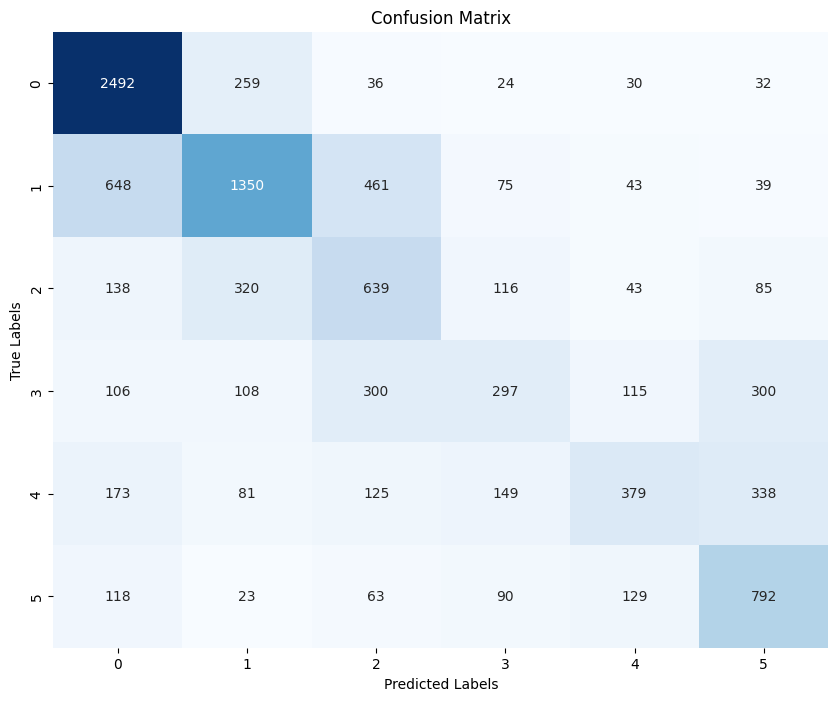

In [ ]:
preds_array = np.array(all_folds_preds)
labels_array = np.array(all_folds_labels)

kappa_score = cohen_kappa_score(labels_array, preds_array, weights='quadratic')
print(f"Overall CV Score: {kappa_score:.4f}")

cm = confusion_matrix(labels_array, preds_array)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

### Plot loss curves

{'epoch': 0, 'fold': 0, 'train_loss': 1.355215936778528, 'tune_loss': 1.3130801887397308, 'kappa': 0.6324481563314508}
{'epoch': 1, 'fold': 0, 'train_loss': 1.125289134168432, 'tune_loss': 1.208838059241513, 'kappa': 0.7051104413913873}
{'epoch': 2, 'fold': 0, 'train_loss': 1.0179823711816116, 'tune_loss': 1.4518631969589786, 'kappa': 0.627505388706141}
{'epoch': 3, 'fold': 0, 'train_loss': 0.9036172080619133, 'tune_loss': 1.0815393271216427, 'kappa': 0.706030144039081}
{'epoch': 4, 'fold': 0, 'train_loss': 0.7813732912424605, 'tune_loss': 1.1979841848453843, 'kappa': 0.7379378539877544}
{'epoch': 5, 'fold': 0, 'train_loss': 0.6550164398273476, 'tune_loss': 1.707483023046011, 'kappa': 0.6496342296452078}
{'epoch': 6, 'fold': 0, 'train_loss': 0.5234924148210147, 'tune_loss': 1.4481563481939845, 'kappa': 0.6800808796725566}
{'epoch': 7, 'fold': 0, 'train_loss': 0.4068158393205419, 'tune_loss': 1.7517779548484158, 'kappa': 0.6455727785522404}
{'epoch': 8, 'fold': 0, 'train_loss': 0.320638

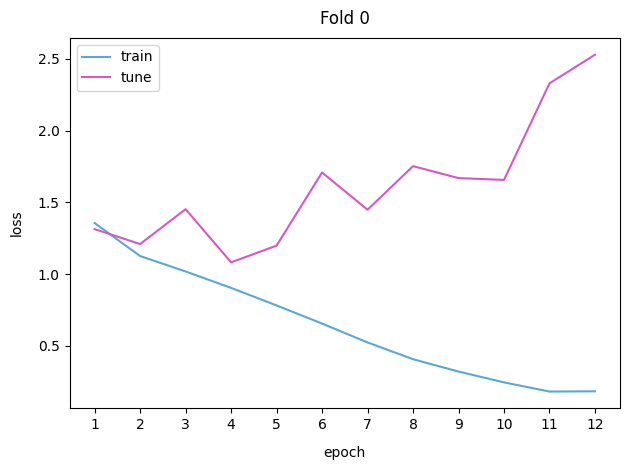

{'epoch': 0, 'fold': 1, 'train_loss': 1.3423367719418606, 'tune_loss': 1.462395130869854, 'kappa': 0.5718332267404282}
{'epoch': 1, 'fold': 1, 'train_loss': 1.1231537299600207, 'tune_loss': 1.1975932494703545, 'kappa': 0.6764652947420982}
{'epoch': 2, 'fold': 1, 'train_loss': 1.033599757472513, 'tune_loss': 1.1215031814862446, 'kappa': 0.7401917566055213}
{'epoch': 3, 'fold': 1, 'train_loss': 0.9087237329618169, 'tune_loss': 2.2793142335960663, 'kappa': 0.23428760735395748}
{'epoch': 4, 'fold': 1, 'train_loss': 0.8085815024520704, 'tune_loss': 1.2312504692249988, 'kappa': 0.7167156580941514}
{'epoch': 5, 'fold': 1, 'train_loss': 0.680065982737522, 'tune_loss': 1.2739285934402282, 'kappa': 0.7108716189625557}
{'epoch': 6, 'fold': 1, 'train_loss': 0.5497232245409537, 'tune_loss': 1.5148490401635688, 'kappa': 0.6957807008118705}
{'epoch': 7, 'fold': 1, 'train_loss': 0.45678871097834967, 'tune_loss': 1.3805685739919364, 'kappa': 0.7337476037014622}
{'epoch': 8, 'fold': 1, 'train_loss': 0.3

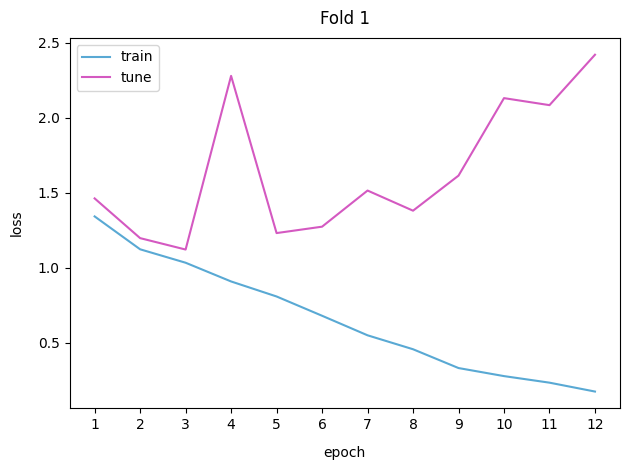

{'epoch': 0, 'fold': 2, 'train_loss': 1.3329372135733786, 'tune_loss': 1.6734484233051898, 'kappa': 0.6127611149110126}
{'epoch': 1, 'fold': 2, 'train_loss': 1.1194542313394276, 'tune_loss': 1.6673919249729938, 'kappa': 0.6051913102693816}
{'epoch': 2, 'fold': 2, 'train_loss': 1.0047363071789144, 'tune_loss': 1.1375430506396007, 'kappa': 0.7206838643689037}
{'epoch': 3, 'fold': 2, 'train_loss': 0.916877756717234, 'tune_loss': 1.153452174491193, 'kappa': 0.7333181526321294}
{'epoch': 4, 'fold': 2, 'train_loss': 0.7904854416847229, 'tune_loss': 1.4923556289040898, 'kappa': 0.6112676902306386}
{'epoch': 5, 'fold': 2, 'train_loss': 0.6698938500784669, 'tune_loss': 1.43967706826796, 'kappa': 0.6973682350037712}
{'epoch': 6, 'fold': 2, 'train_loss': 0.5669277350188267, 'tune_loss': 1.4225119481603783, 'kappa': 0.6881885932336653}
{'epoch': 7, 'fold': 2, 'train_loss': 0.4231692049727749, 'tune_loss': 1.925168112099889, 'kappa': 0.6068376465506786}
{'epoch': 8, 'fold': 2, 'train_loss': 0.34008

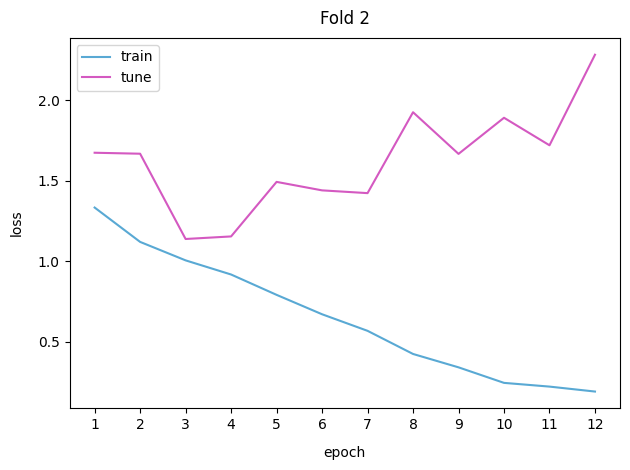

{'epoch': 0, 'fold': 3, 'train_loss': 1.3423351959178322, 'tune_loss': 1.2367163524929299, 'kappa': 0.6006987005991642}
{'epoch': 1, 'fold': 3, 'train_loss': 1.1362928074863758, 'tune_loss': 1.2198886767209294, 'kappa': 0.6615789333466251}
{'epoch': 2, 'fold': 3, 'train_loss': 1.0175191636992853, 'tune_loss': 1.104352194860757, 'kappa': 0.7283869815590129}
{'epoch': 3, 'fold': 3, 'train_loss': 0.8972113775579553, 'tune_loss': 1.150650909507131, 'kappa': 0.7242692831176849}
{'epoch': 4, 'fold': 3, 'train_loss': 0.7841026433083692, 'tune_loss': 1.236660283732127, 'kappa': 0.6474998677534013}
{'epoch': 5, 'fold': 3, 'train_loss': 0.6437041512143756, 'tune_loss': 1.345086137214339, 'kappa': 0.7141809239012944}
{'epoch': 6, 'fold': 3, 'train_loss': 0.5045467192827449, 'tune_loss': 1.5217728140842484, 'kappa': 0.6199774033920039}
{'epoch': 7, 'fold': 3, 'train_loss': 0.3786486057858718, 'tune_loss': 2.110987252499684, 'kappa': 0.6415829123296408}
{'epoch': 8, 'fold': 3, 'train_loss': 0.30760

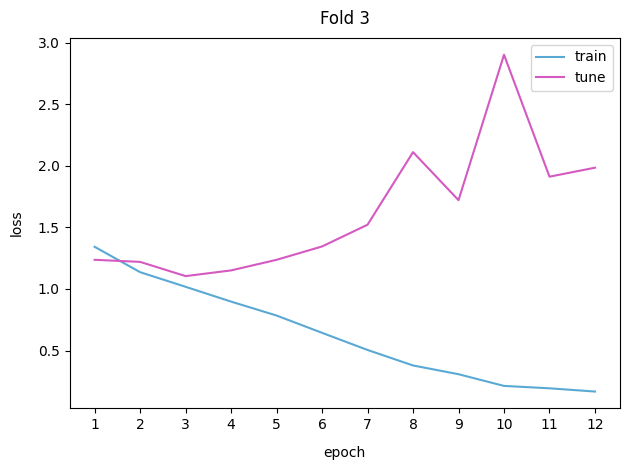

In [ ]:
import matplotlib.pyplot as plt

for fold in range(nfolds):
    with open(f'/kaggle/working/logs/log_{fname}_{fold}.json') as f:
        d = json.load(f)
        epoch = []
        train_loss = []
        tune_loss = []
        kappa = []
        for sd in d:
            print(sd)
            epoch.append(sd['epoch'])
            train_loss.append(sd['train_loss'])
            tune_loss.append(sd['tune_loss'])
            kappa.append(sd['kappa'])



    plt.figure(dpi=100)
    plt.plot(train_loss, label='train', color="#59A9D4")
    plt.plot(tune_loss, label='tune', color="#D459C1")

    plt.title(f'Fold {fold}', pad=10)
    plt.xlabel('epoch', labelpad=10)
    plt.ylabel('loss', labelpad=10)
    plt.xticks(range(len(train_loss)), range(1, len(train_loss)+1))  # Assuming epochs start at 1
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'log_{fname}_{fold}.png')
    plt.show()

### Mock predictions